In [1]:
# from jax.config import config
# config.update('jax_enable_x64', True)

import jax.numpy as jnp
import jax

import numpy as np

from functools import partial

import matplotlib
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
from trajax import integrators

from trajax.experimental.sqp import util
from importlib import reload

reload(util)

<module 'trajax.experimental.sqp.util' from '/home/qdeng/.pyenv/versions/3.12.1/envs/AA203/lib/python3.12/site-packages/trajax/experimental/sqp/util.py'>

In [3]:
from trajax.optimizers import ilqr
from flax import struct
import chex

Array = jax.Array
Scalar = chex.Scalar

In [4]:
# Do angle wrapping on theta and phi
s1_ind = (0, 1)
state_wrap = util.get_s1_wrapper(s1_ind)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
n = 4
m = 1

In [6]:
@struct.dataclass
class AcrobotDynamicsParams:
    
    LINK_MASS_1: float = 1.0
    LINK_MASS_2: float = 1.0
    LINK_LENGTH_1: float = 1.0
    LINK_COM_POS_1: float = 0.5
    LINK_COM_POS_2: float = 0.5
    LINK_MOI_1: float = 1.0
    LINK_MOI_2: float = 1.0


def acrobot(
    x: Array,
    u: Array,
    t: Scalar,
    params: AcrobotDynamicsParams
) -> Array:
    """Classic Acrobot system.

    Note this implementation emulates the OpenAI gym implementation of
    Acrobot-v2, which itself is based on Stutton's Reinforcement Learning book.

    https://gymnasium.farama.org/environments/classic_control/acrobot/

    Args:
      x: state, (4, ) array
      u: control, (1, ) array
      t: scalar time. Disregarded because system is time-invariant.
      params: tuple of (LINK_MASS_1, LINK_MASS_2, LINK_LENGTH_1, LINK_COM_POS_1,
        LINK_COM_POS_2 LINK_MOI_1, LINK_MOI_2)

    Returns:
      xdot: state time derivative, (4, )
    """
    del t  # Unused

    m1, m2, l1, lc1, lc2, I1, I2 = jax.flatten_util.ravel_pytree(params)[0]
    g = 9.8
    a = u[0] #+ 10*(np.random.rand()-0.5)#jax.random.uniform(jax.random.PRNGKey(0),minval=-5,maxval=5,shape=(1,1))[0]
    theta1 = x[0]
    theta2 = x[1]
    dtheta1 = x[2]
    dtheta2 = x[3]
    d1 = (
        m1 * lc1**2 + m2 * (l1**2 + lc2**2 + 2 * l1 * lc2 * jnp.cos(theta2)) + I1 +
        I2)
    d2 = m2 * (lc2**2 + l1 * lc2 * jnp.cos(theta2)) + I2
    phi2 = m2 * lc2 * g * jnp.cos(theta1 + theta2 - jnp.pi / 2.)
    phi1 = (-m2 * l1 * lc2 * dtheta2**2 * jnp.sin(theta2) -
            2 * m2 * l1 * lc2 * dtheta2 * dtheta1 * jnp.sin(theta2) +
            (m1 * lc1 + m2 * l1) * g * jnp.cos(theta1 - jnp.pi / 2) + phi2)
    ddtheta2 = ((a + d2 / d1 * phi1 -
                 m2 * l1 * lc2 * dtheta1**2 * jnp.sin(theta2) - phi2) /
                (m2 * lc2**2 + I2 - d2**2 / d1))
    ddtheta1 = -(d2 * ddtheta2 + phi1) / d1
    return jnp.array([dtheta1, dtheta2, ddtheta1, ddtheta2])


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
import matplotlib.animation as animation

def animate_acrobot(x, t, params: AcrobotDynamicsParams, filename='test_scp', dt=0.1):
    m1, m2, l1, lc1, lc2, I1, I2 = jax.flatten_util.ravel_pytree(params)[0]
    l2 = l1
    
    ## Convert Theta to Position
    pos_x_elbow = l1*jnp.sin(x[:,0]) 
    pos_y_elbow = -l1*jnp.cos(x[:,0]) 
    
    pos_x_end = pos_x_elbow+l2*jnp.sin(x[:,0]+x[:,1]) 
    pos_y_end = pos_y_elbow-l2*jnp.cos(x[:,0]+x[:,1]) 

    # Figure and axis
    fig, ax = plt.subplots(dpi=100)
    x_min, x_max, y_min, y_max = -1.1 * (l1+l2), 1.1 * (l1+l2), -1.1 * (l1+l2), 1.1 * (l1+l2)
    ax.plot(0.0, 0.0, "X", linewidth=0.1, color="k")#[0]
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_yticks([])
    ax.set_aspect(1.0)
    
    # Artists
    link1 = ax.plot([], [], "-", linewidth=3, color="b")[0]
    link2 = ax.plot([], [], "-", linewidth=3, color="g")[0]
    elbow = ax.plot([], [], "ro", linewidth=3)[0]
    trace = ax.plot([], [], "--", linewidth=2, color="tab:orange")[0]
    timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)
    
    def animate(k, t):
        # Geometry
        link1.set_data([0, pos_x_elbow[k]], [0, pos_y_elbow[k]])
        link2.set_data([pos_x_elbow[k], pos_x_end[k]], [pos_y_elbow[k], pos_y_end[k]])
        elbow.set_data([pos_x_elbow[k], pos_x_elbow[k]], [pos_y_elbow[k],pos_y_elbow[k]])
        trace.set_data(pos_x_end[:k], pos_y_end[:k])
    
        # Time-stamp
        timestamp.set_text("t = {:.1f} s".format(t[k]))
    
        artists = (link1, link2, elbow, trace, timestamp)
        return artists
    
    ani = animation.FuncAnimation(
        fig, animate, t.size, fargs=(t,), interval=dt * 1000, blit=True
    )

    # filename = 'test_scp_fine'

    ani.save(f"{filename}.mp4", writer="ffmpeg")
    fig.savefig(f'./{filename}.png') 
            

In [10]:
dt = 0.1
T = 50
goal = jnp.array([jnp.pi, 0.0, 0.0, 0.0])


@struct.dataclass
class AcrobotCostParams:
    stage_cost_x: float = 0.1
    stage_cost_u: float = 0.01
    term_cost_x: float = 1000.0


def acrobot_cost(
    x: Array,
    u: Array,
    t: Scalar,
    params: AcrobotCostParams
) -> float:
    # delta = state_wrap(x - goal)
    delta = x - goal
    terminal_cost = 0.5 * params.term_cost_x * jnp.dot(delta, delta)
    stage_cost = 0.5 * params.stage_cost_x * jnp.dot(
        delta, delta) + 0.5 * params.stage_cost_u * jnp.dot(u, u)
    return jnp.where(t == T, terminal_cost, stage_cost)


In [11]:
def acrobot_soln(
    dynamics_params: AcrobotDynamicsParams, 
    cost_params: AcrobotCostParams,
) -> float:
    dynamics = integrators.euler(
        partial(acrobot, params=dynamics_params), dt=0.1)
    x0 = jnp.zeros(4)#np.random.rand(4)
    U = jnp.zeros((T, 1))
    return ilqr(
        partial(acrobot_cost, params=cost_params),
        dynamics, x0, U,
        maxiter=100, make_psd=False, vjp_method='explicit')
    # return jnp.sum(U ** 2)


In [12]:
dynamics_params = AcrobotDynamicsParams()
cost_params = AcrobotCostParams()
soln = acrobot_soln(dynamics_params, cost_params)

In [13]:
soln[0].shape

(51, 4)

In [14]:
soln[1].shape

(50, 1)

In [15]:
x_sim = [soln[0][0,:]]
dynamics = integrators.euler(partial(acrobot, params=dynamics_params), dt=0.1)

for u in soln[1]:
    x_next = dynamics(x_sim[-1], u, 0)
    x_sim.append(x_next)

x_sim = np.array(x_sim)

x_sim

array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  5.8458036e-01, -1.5032066e+00],
       [ 5.8458038e-02, -1.5032066e-01,  9.4422472e-01, -2.4280062e+00],
       [ 1.5288052e-01, -3.9312130e-01,  1.1408798e+00, -2.9631443e+00],
       [ 2.6696849e-01, -6.8943572e-01,  1.1991327e+00, -3.1989334e+00],
       [ 3.8688177e-01, -1.0093291e+00,  1.1343973e+00, -3.1939390e+00],
       [ 5.0032151e-01, -1.3287230e+00,  9.6823806e-01, -3.0118983e+00],
       [ 5.9714532e-01, -1.6299129e+00,  7.2577429e-01, -2.7159541e+00],
       [ 6.6972274e-01, -1.9015083e+00,  4.2808351e-01, -2.3495824e+00],
       [ 7.1253109e-01, -2.1364665e+00,  9.1077924e-02, -1.9324124e+00],
       [ 7.2163886e-01, -2.3297076e+00, -2.7117884e-01, -1.4694040e+00],
       [ 6.9452095e-01, -2.4766481e+00, -6.4384001e-01, -9.6254194e-01],
       [ 6.3013697e-01, -2.5729022e+00, -1.0101860e+00, -4.1922182e-01],
       [ 5.2911836e-01, -2.6148243e+00, -1.3505362e

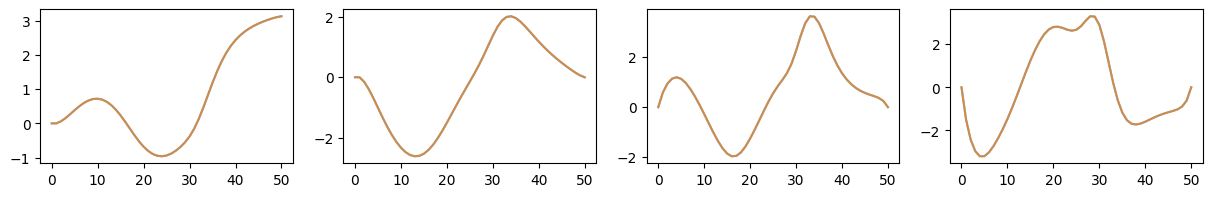

In [16]:
n = 4
fig, ax = plt.subplots(1, n, figsize=(15, 2))

for i in range(n):
    ax[i].plot(soln[0][:,i], alpha=2/3)
    ax[i].plot(x_sim[:,i], alpha=2/3)
    

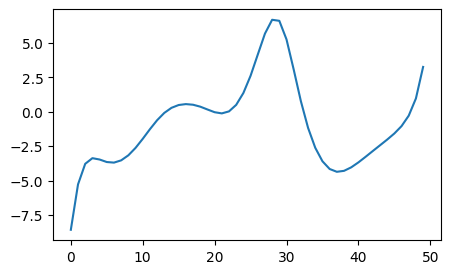

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(soln[1])

In [18]:
np.arange(0, T+1)*0.1

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])

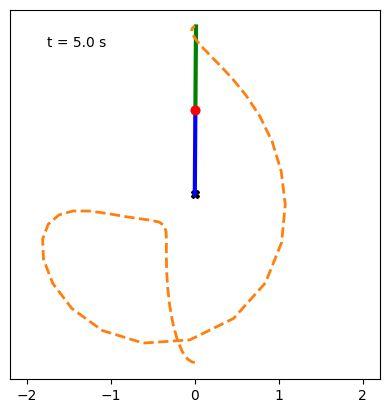

In [19]:
animate_acrobot(soln[0], np.arange(0, T+1)*0.1, dynamics_params,filename='test_trajax_ilqr')

In [17]:
k = 0
x0 = soln[0][k,:]#jnp.zeros(4)
U = np.concatenate([soln[1][k:,:], jnp.zeros((k, 1))])
x0 = jnp.zeros(4)
U = jnp.zeros((60, 1))
# dynamics = integrators.euler(partial(acrobot, params=dynamics_params), dt=0.1)
soln_k = acrobot_solve(dynamics_params, cost_params, x0, U, myT, N_ilqr)

NameError: name 'acrobot_solve' is not defined

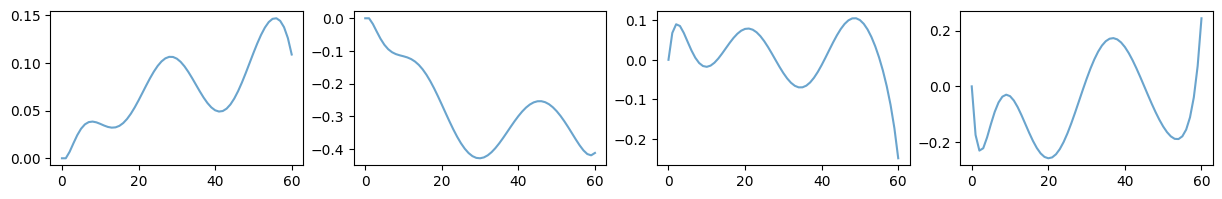

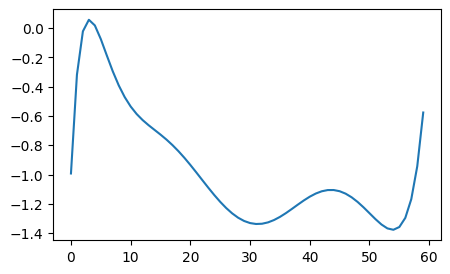

In [44]:
n = 4
fig, ax = plt.subplots(1, n, figsize=(15, 2))

for i in range(n):
    ax[i].plot(soln_k[0][:,i], alpha=2/3)
    # ax[i].plot(x_sim[:,i], alpha=2/3)

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(soln_k[1])

### MPC with iLQR

In [22]:
goal = jnp.array([jnp.pi, 0.0, 0.0, 0.0]) #jnp.pi


@struct.dataclass
class AcrobotCostParams:
    stage_cost_x: float = 0.1
    stage_cost_u: float = 0.01
    term_cost_x: float = 1000.0

N_mpc = 50  # MPC horizon; horizon length is related to how fast the system is going to converge;for some disturbances we should have a fast convergence and short horizon
N_ilqr = 20  # maximum number of LQR iterations

dynamics_params = AcrobotDynamicsParams()
cost_params = AcrobotCostParams()

myT = 100  # total simulation time step
dt = 0.1
t = np.arange(0.0, (myT)*dt, dt)
x_mpc = np.zeros((myT , N_mpc+1, n))
u_mpc = np.zeros((myT , N_mpc, m))

# x_mpc_rand = np.zeros((myT , N_mpc+1, n))
# u_mpc_rand = np.zeros((myT , N_mpc, m))

In [23]:
x_mpc.shape

(100, 51, 4)

In [24]:
def acrobot_cost_mpc(
    x: Array,
    u: Array,
    t: Scalar,
    # T: Scalar,
    params: AcrobotCostParams
) -> float:
    delta = x - goal
    terminal_cost = 0.5 * params.term_cost_x * jnp.dot(delta, delta)
    stage_cost = 0.5 * params.stage_cost_x * jnp.dot(
        delta, delta) + 0.5 * params.stage_cost_u * jnp.dot(u, u)
    return jnp.where(t == N_mpc, terminal_cost, stage_cost) # In MPC, the terminal cost should be the end of the horizon instead of end of simulation time


In [25]:
@jax.jit
def acrobot_solve(
    dynamics_params: AcrobotDynamicsParams, 
    cost_params: AcrobotCostParams,
    x0,
    U,
    lqr_inter
) -> float:
    dynamics = integrators.euler(
        partial(acrobot, params=dynamics_params), dt=0.1)
    return ilqr(
        partial(acrobot_cost_mpc, params=cost_params,),
        dynamics, x0, U,
        maxiter=lqr_inter, make_psd=False, vjp_method='explicit')
    # return jnp.sum(U ** 2)


In [26]:
(np.random.rand(4)-0.5)*0.001

array([ 2.75544314e-05, -2.95096128e-05,  4.68971507e-04,  2.84694541e-04])

In [37]:
x0 = jnp.zeros(4)
U = jnp.zeros((N_mpc, 1))

x0_rand = jnp.zeros(4)
U_rand = jnp.zeros((N_mpc, 1))

np.random.seed(1)

dynamics = integrators.euler(partial(acrobot, params=dynamics_params), dt=0.1)
for k in tqdm(range(myT)):
    
    
    soln = acrobot_solve(dynamics_params, cost_params, x0, U, N_ilqr)

    x_mpc[k,:,:] = soln[0]
    u_mpc[k,:,:] = soln[1]


    # ax[i].plot(x_mpc[6,:,i]
    x0 = dynamics(x_mpc[k,0,:], u_mpc[k,0,:], 0) #+ (np.random.rand(1)-0.5)*5
    # x0 += (np.random.rand(4)-0.5)*0.0005
    # print(x0)#+ (np.random.rand(1,4)-0.5)*0.001
    U = np.concatenate([soln[1][1:], np.zeros((1,1))])

    # soln = acrobot_solve(dynamics_params, cost_params, x0_rand, U_rand, N_ilqr)
    # x_mpc_rand[k,:,:] = soln[0]
    # u_mpc_rand[k,:,:] = soln[1]
    # disturb = 0.01*(np.random.rand(1)-0.5)

    # u_mpc_rand[k,0,:] += disturb

    # x0_rand = dynamics(x_mpc_rand[k,0,:], u_mpc_rand[k,0,:], 0)
    # U_rand = np.concatenate([soln[1][1:], np.zeros((1,1))])
    
    # break

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 200.47it/s]


In [38]:
# soln

In [39]:
(np.random.rand()-0.5)

-0.082977995297426

In [40]:
U.shape

(50, 1)

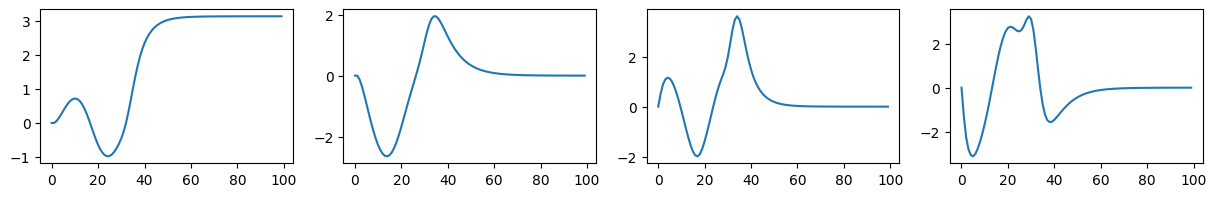

In [41]:
n = 4
fig, ax = plt.subplots(1, n, figsize=(15, 2))

for i in range(n):
    ax[i].plot(x_mpc[:,0,i])

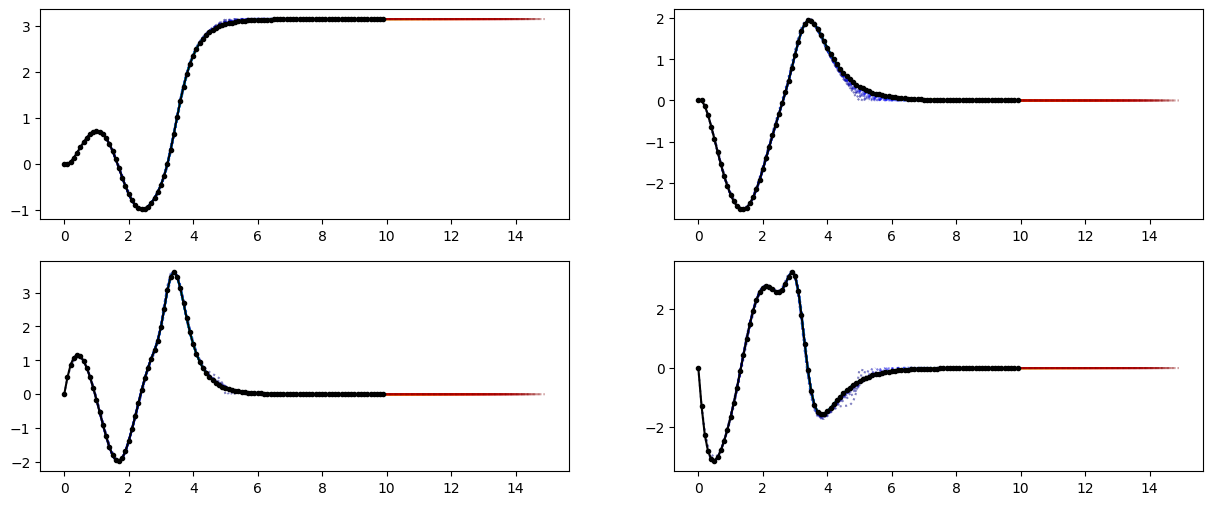

In [42]:
fig, ax = plt.subplots(n//2, n//2, figsize=(15, 6))


colors = plt.cm.jet(np.linspace(0,1,len(t)))

for i in range(n):

    # print(i)

    for k, t_k in enumerate(t):
        t_series = np.linspace(t_k, t_k+(N_mpc)*dt, num=N_mpc+1)#np.arange(t_k, t_k+(N_mpc+1)*dt, dt)[:11]
        # print(t_series , len(t_series))
        ax[i//2,i%2].plot(t_series, x_mpc[k,:,i],':', color=colors[k],alpha=0.5)

    ax[i//2,i%2].plot(t,x_mpc[:,0,i],'k.-')
    # ax[i//2,i%2].plot(t,x_mpc_rand[:,0,i],'b.-')

# for t in range(T):
#     ax[0].plot(s_mpc[t, :, 0], s_mpc[t, :, 1], "--*", color="k")

# np.linspace(t_k, t_k+(N_mpc)*dt, num=N_mpc+1)

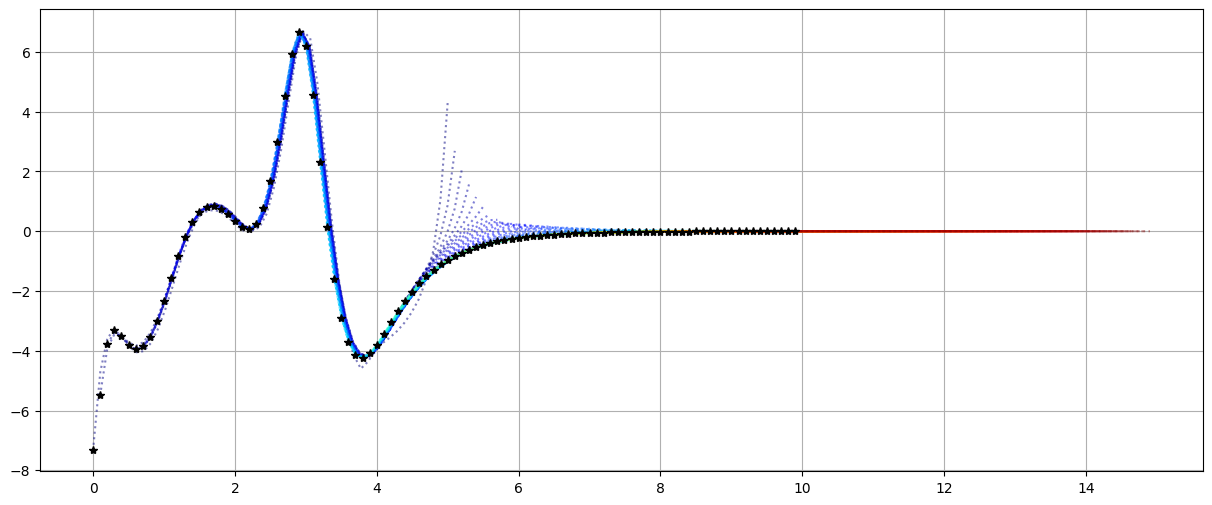

In [43]:
fig, ax = plt.subplots( figsize=(15, 6))

for k, t_k in enumerate(t):
    t_series = np.linspace(t_k, t_k+(N_mpc)*dt, num=N_mpc)#np.arange(t_k, t_k+(N_mpc+1)*dt, dt)[:11]
    # print(t_series , len(t_series))
    ax.plot(t_series, u_mpc[k,:],':', color=colors[k], alpha=0.5)
ax.plot(t,u_mpc[:,0],'k*')
# ax.plot(t,u_mpc_rand[:,0],'b*')
ax.grid()

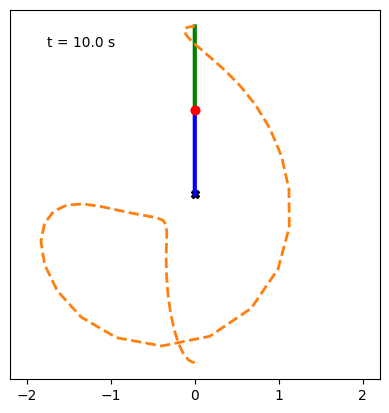

In [44]:
animate_acrobot(x_mpc[:,0,:], np.arange(0, myT+1)*0.1, dynamics_params,filename='test_trajax_ilqr_mpc')

In [45]:
dynamics = integrators.euler(
        partial(acrobot, params=dynamics_params), dt=0.1)
dynamics(soln[0][0],soln[1][0], 0)

Array([ 3.1415136e+00,  4.3904193e-04,  9.5016010e-05, -5.2856520e-04],      dtype=float32)

In [46]:
i

3

In [47]:
k

99

In [48]:
x_mpc.shape

(100, 51, 4)

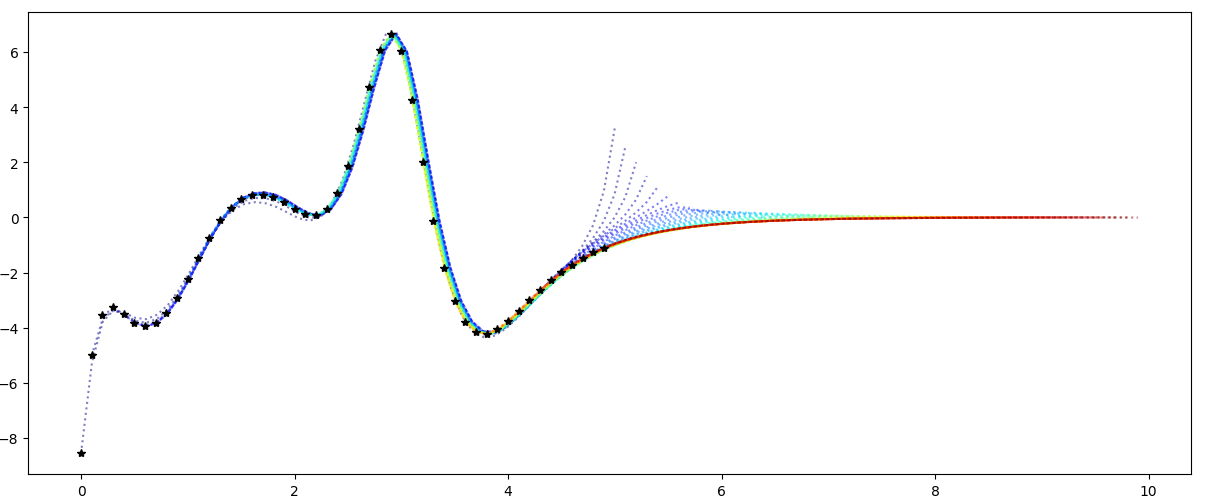

### MPC with model parameter mismatch

In [105]:
@struct.dataclass
class MisAcrobotDynamicsParams:
    
    LINK_MASS_1: float = 1.0
    LINK_MASS_2: float = 1.05
    LINK_LENGTH_1: float = 1.0
    LINK_COM_POS_1: float = 0.5
    LINK_COM_POS_2: float = 0.5
    LINK_MOI_1: float = 1.0
    LINK_MOI_2: float = 1.0

In [137]:
goal = jnp.array([jnp.pi, 0.0, 0.0, 0.0]) #jnp.pi


@struct.dataclass
class AcrobotCostParams:
    stage_cost_x: float = 0.1 * 100
    stage_cost_u: float = 0.01 * 100
    term_cost_x: float = 1000.0

N_mpc = 30  # MPC horizon; horizon length is related to how fast the system is going to converge;for some disturbances we should have a fast convergence and short horizon
N_ilqr = 20  # maximum number of LQR iterations

model_dynamics_params = AcrobotDynamicsParams()
actual_dynamics_params = MisAcrobotDynamicsParams()
cost_params = AcrobotCostParams()

myT = 100  # total simulation time step
dt = 0.1
t = np.arange(0.0, (myT)*dt, dt)
x_mpc = np.zeros((myT , N_mpc+1, n))
u_mpc = np.zeros((myT , N_mpc, m))

# x_mpc_rand = np.zeros((myT , N_mpc+1, n))
# u_mpc_rand = np.zeros((myT , N_mpc, m))

In [138]:
x0 = jnp.zeros(4)
U = jnp.zeros((N_mpc, 1))

x0_rand = jnp.zeros(4)
U_rand = jnp.zeros((N_mpc, 1))

np.random.seed(1)

dynamics = integrators.euler(partial(acrobot, params=actual_dynamics_params), dt=0.1)

min_horizon = 20

J_initial = None
for k in tqdm(range(myT)):
    soln = acrobot_solve(model_dynamics_params, cost_params, x0, U, N_ilqr)
    x_mpc[k,:,:] = soln[0]
    u_mpc[k,:,:] = soln[1]

    # if J_initial is None:
    #     # Scale the MPC horizon if the state is getting closer 
    #     J_initial = soln[2]
    #     # print(soln[2])
    # else:
    #     suggested_N_mpc = min([50, max([50 * soln[2] / J_initial, min_horizon])])
    #     if suggested_N_mpc < N_mpc:
    #         N_mpc = 
    # else:
    #     N_mpc = min([50, max([50 * soln[2] / J_initial, min_horizon])])

    # print(N_mpc, soln[2])

    # ax[i].plot(x_mpc[6,:,i]
    x0 = dynamics(x_mpc[k,0,:], u_mpc[k,0,:], 0) #+ (np.random.rand(1)-0.5)*5
    # x0 += (np.random.rand(4)-0.5)*0.0005
    # print(x0)#+ (np.random.rand(1,4)-0.5)*0.001
    U = np.concatenate([soln[1][1:], np.zeros((1,1))])

    # soln = acrobot_solve(dynamics_params, cost_params, x0_rand, U_rand, N_ilqr)
    # x_mpc_rand[k,:,:] = soln[0]
    # u_mpc_rand[k,:,:] = soln[1]
    # disturb = 0.01*(np.random.rand(1)-0.5)

    # u_mpc_rand[k,0,:] += disturb

    # x0_rand = dynamics(x_mpc_rand[k,0,:], u_mpc_rand[k,0,:], 0)
    # U_rand = np.concatenate([soln[1][1:], np.zeros((1,1))])
    
    # break

 21%|████████▊                                 | 21/100 [00:02<00:06, 12.86it/s]

30 5215.1934
30 4987.6543
30 4750.873
30 4482.4775
30 4208.775
30 3961.355
30 3758.3154
30 3601.7793
30 3486.3132
30 3404.6348
30 3349.5193
30 3314.3853
30 3292.5278
30 3258.1165
30 3194.5835
30 3110.0942
30 3008.4478
30 2891.3923
30 2761.5652
30 2622.8203
30 2479.518
30 2335.728
30 2194.623
30 2058.1382
30 1926.882
30 1800.0869
30 1675.6616
30 1550.1752
30 1419.1631
30 1278.6433
30 1128.8634
30 977.69147
30 836.9069
30 712.62555
30 603.58307
30 509.52594
30 436.4613
30 386.59033
30 346.8496
30 300.4476
30 249.4851


 58%|████████████████████████▎                 | 58/100 [00:02<00:00, 42.24it/s]

30 200.1866
30 155.75047
30 117.49066
30 86.20612
30 62.30223
30 45.35419
30 34.081463
30 26.850548
30 22.197828
30 19.055801
30 16.747124
30 14.882542
30 13.258496
30 11.780001
30 10.410686
30 9.141191
30 7.973494
30 6.911259
30 5.9563966
30 5.1076717
30 4.360967
30 3.7098353
30 3.1463642
30 2.6617944
30 2.2473729
30 1.8944504
30 1.5949701
30 1.3415778
30 1.1276664
30 0.9473896
30 0.79566294
30 0.66810226
30 0.56094
30 0.47094905


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 37.21it/s]

30 0.3954038
30 0.33201355
30 0.2788157
30 0.2341804
30 0.19672449
30 0.16528225
30 0.1388919
30 0.11673173
30 0.09811635
30 0.08248204
30 0.06934545
30 0.058309186
30 0.04903643
30 0.04123986
30 0.034687288
30 0.029181356
30 0.024546208
30 0.020648202
30 0.017372902
30 0.014616124
30 0.012296732
30 0.010345591
30 0.008704174
30 0.0073238653
30 0.0061622164


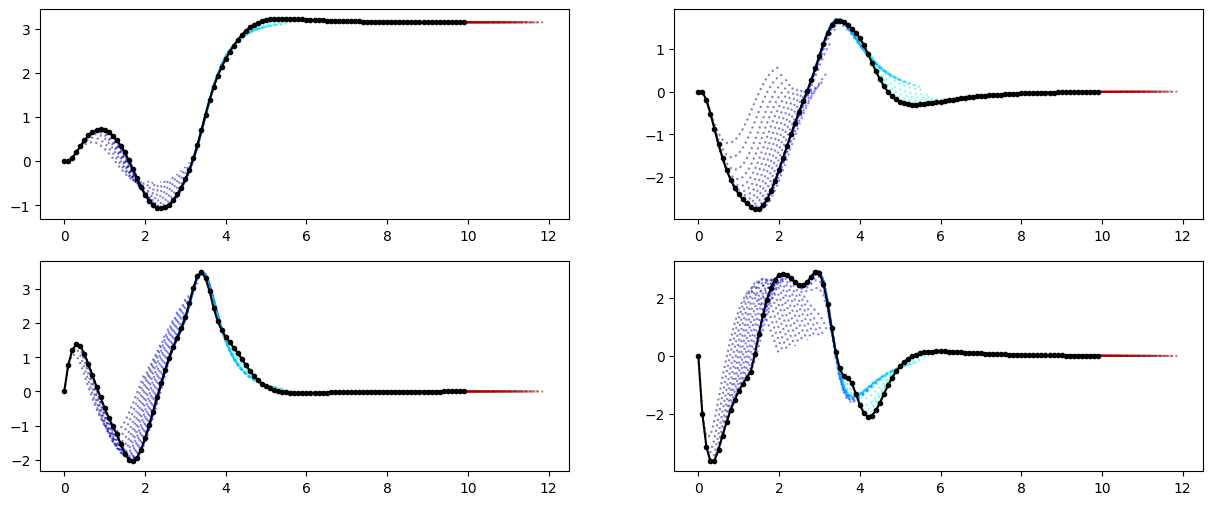

In [139]:
fig, ax = plt.subplots(n//2, n//2, figsize=(15, 6))


colors = plt.cm.jet(np.linspace(0,1,len(t)))

for i in range(n):

    # print(i)

    for k, t_k in enumerate(t):
        t_series = np.linspace(t_k, t_k+(min_horizon)*dt, num=min_horizon+1)#np.arange(t_k, t_k+(N_mpc+1)*dt, dt)[:11]
        # print(t_series , len(t_series))
        ax[i//2,i%2].plot(t_series, x_mpc[k,:min_horizon+1,i],':', color=colors[k],alpha=0.5)

    ax[i//2,i%2].plot(t,x_mpc[:,0,i],'k.-')
    # ax[i//2,i%2].plot(t,x_mpc_rand[:,0,i],'b.-')

# for t in range(T):
#     ax[0].plot(s_mpc[t, :, 0], s_mpc[t, :, 1], "--*", color="k")

# np.linspace(t_k, t_k+(N_mpc)*dt, num=N_mpc+1)

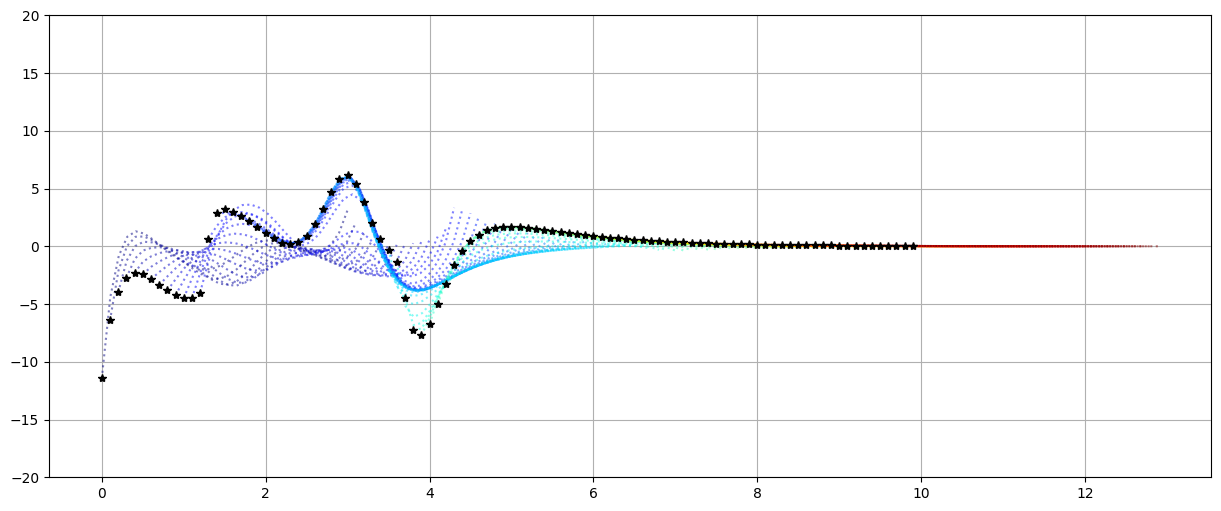

In [144]:
fig, ax = plt.subplots( figsize=(15, 6))

for k, t_k in enumerate(t):
    t_series = np.linspace(t_k, t_k+(N_mpc)*dt, num=N_mpc)#np.arange(t_k, t_k+(N_mpc+1)*dt, dt)[:11]
    # print(t_series , len(t_series))
    ax.plot(t_series, u_mpc[k,:],':', color=colors[k], alpha=0.5)
ax.plot(t,u_mpc[:,0],'k*')
# ax.plot(t,u_mpc_rand[:,0],'b*')
ax.set_ylim([-20, 20])
ax.grid()

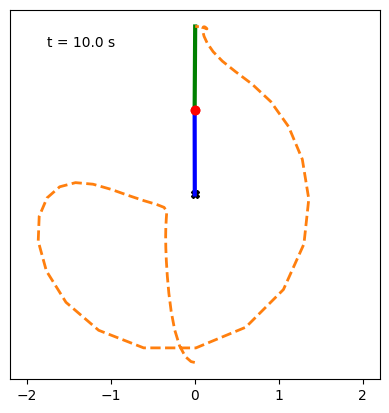

In [141]:
animate_acrobot(x_mpc[:,0,:], np.arange(0, myT+1)*0.1, dynamics_params,filename='test_trajax_ilqr_mpc_model_mismatch')